In [1]:
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import cv2
import os
import time
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [17]:
!nvidia-smi


zsh:1: command not found: nvidia-smi


In [3]:
weightsfile = './yolov3.weights'
classfile = './coco.names'
cfgfile = './yolov3.cfg'
sample_img1 = './input/dog-cycle-car.png'
input_dir = './input'
output_dir = './output'
nms_thesh = 0.5

In [4]:
if not os.path.exists(input_dir):
    os.mkdir(input_dir)

In [5]:
def parse_cfg(config_file):
    file = open(config_file,'r')
    file = file.read().split('\n')
    file =  [line for line in file if len(line)>0 and line[0] != '#']
    file = [line.lstrip().rstrip() for line in file]

    final_list = []
    element_dict = {}
    for line in file:

        if line[0] == '[':
            if len(element_dict) != 0:     # appending the dict stored on previous iteration
                    final_list.append(element_dict)
                    element_dict = {} # again emtying dict
            element_dict['type'] = ''.join([i for i in line if i != '[' and i != ']'])
            
        else:
            val = line.split('=')
            element_dict[val[0].rstrip()] = val[1].lstrip()  #removing spaces on left and right side
        
    final_list.append(element_dict) # appending the values stored for last set
    return final_list

In [6]:
class DummyLayer(nn.Module):
    def __init__(self):
        super(DummyLayer, self).__init__()
        

        
class DetectionLayer(nn.Module):
    def __init__(self, anchors):
        super(DetectionLayer, self).__init__()
        self.anchors = anchors
        
        

def create_model(blocks):
#     blocks = parse_cfg(cfgfile)
    darknet_details = blocks[0]
    channels = 3 
    output_filters = []
    modulelist = nn.ModuleList()
    
    for i,block in enumerate(blocks[1:]):
        seq = nn.Sequential()
        if (block["type"] == "convolutional"):
            activation = block["activation"]
            filters = int(block["filters"])
            kernel_size = int(block["size"])
            strides = int(block["stride"])
            use_bias= False if ("batch_normalize" in block) else True
            pad = (kernel_size - 1) // 2
            
            conv = nn.Conv2d(in_channels=channels, out_channels=filters, kernel_size=kernel_size, 
                             stride=strides, padding=pad, bias = use_bias)
            seq.add_module("conv_{0}".format(i), conv)
            
            if "batch_normalize" in block:
                bn = nn.BatchNorm2d(filters)
                seq.add_module("batch_norm_{0}".format(i), bn)

            if activation == "leaky":
                activn = nn.LeakyReLU(0.1, inplace = True)
                seq.add_module("leaky_{0}".format(i), activn)
            
        elif (block["type"] == "upsample"):
            upsample = nn.Upsample(scale_factor = 2, mode = "bilinear")
            seq.add_module("upsample_{}".format(i), upsample)
        
        elif (block["type"] == 'route'):
            # start and end is given in format (eg:-1 36 so we will find layer number from it.
            # we will find layer number in negative format
            # so that we can get the number of filters in that layer
            block['layers'] = block['layers'].split(',')
            block['layers'][0] = int(block['layers'][0])
            start = block['layers'][0]
            if len(block['layers']) == 1:               
                filters = output_filters[i + start]
                       
            
            elif len(block['layers']) > 1:
                block['layers'][1] = int(block['layers'][1]) - i 
                end = block['layers'][1]
                filters = output_filters[i + start] + output_filters[i + end]
                  
            
            route = DummyLayer()
            seq.add_module("route_{0}".format(i),route)
                
      
        elif block["type"] == "shortcut":
            from_ = int(block["from"])
            shortcut = DummyLayer()
            seq.add_module("shortcut_{0}".format(i),shortcut)
            
            
        elif block["type"] == "yolo":
            mask = block["mask"].split(",")
            mask = [int(m) for m in mask]
            anchors = block["anchors"].split(",")
            anchors = [(int(anchors[i]), int(anchors[i + 1])) for i in range(0, len(anchors), 2)]
            anchors = [anchors[i] for i in mask]
            block["anchors"] = anchors
            
            detectorLayer = DetectionLayer(anchors)
            seq.add_module("Detection_{0}".format(i),detectorLayer)
                
        modulelist.append(seq)
        output_filters.append(filters)  
        channels = filters
    
    return darknet_details, modulelist

## Model

In [7]:
def yolo_prediction(x,inp_dim,anchors,num_classes,CUDA=False):
    # x --> 4D feature map
    batch_size = x.size(0)
    grid_size = x.size(2)
    stride =  inp_dim // x.size(2)   # factor by which current feature map reduced from input
#     grid_size = inp_dim // stride
    
    bbox_attrs = 5 + num_classes
    num_anchors = len(anchors)
# 
    yolo_prediction = x.view(batch_size, bbox_attrs*num_anchors, grid_size*grid_size)
    yolo_prediction = yolo_prediction.transpose(1,2).contiguous()
    yolo_prediction = yolo_prediction.view(batch_size, grid_size*grid_size*num_anchors, bbox_attrs)
    
    # the dimension of anchors is wrt original image.We will make it corresponding to feature map
    anchors = [(a[0]/stride, a[1]/stride) for a in anchors]
    #Sigmoid the  centre_X, centre_Y. and object confidencce
    yolo_prediction[:,:,0] = torch.sigmoid(yolo_prediction[:,:,0])
    yolo_prediction[:,:,1] = torch.sigmoid(yolo_prediction[:,:,1])
    yolo_prediction[:,:,4] = torch.sigmoid(yolo_prediction[:,:,4])
    #Add the center offsets
    grid = np.arange(grid_size)
    a,b = np.meshgrid(grid, grid)

    x_offset = torch.FloatTensor(a).view(-1,1) #(1,gridsize*gridsize,1)
    y_offset = torch.FloatTensor(b).view(-1,1)

    if CUDA:
        x_offset = x_offset.cuda()
        y_offset = y_offset.cuda()

    x_y_offset = torch.cat((x_offset, y_offset), 1).repeat(1,num_anchors).view(-1,2).unsqueeze(0)
    

    yolo_prediction[:,:,:2] += x_y_offset

    #log space transform height and the width
    anchors = torch.FloatTensor(anchors)

    if CUDA:
        anchors = anchors.cuda()

    anchors = anchors.repeat(grid_size*grid_size, 1).unsqueeze(0)
    yolo_prediction[:,:,2:4] = torch.exp(yolo_prediction[:,:,2:4])*anchors #width and height
    yolo_prediction[:,:,5: 5 + num_classes] = torch.sigmoid((yolo_prediction[:,:, 5 : 5 + num_classes]))    
    yolo_prediction[:,:,:4] *= stride    
    return yolo_prediction

In [8]:
class Darknet(nn.Module):
    def __init__(self, cfgfile):
        super(Darknet, self).__init__()
        self.blocks = parse_cfg(cfgfile)
        self.net_info, self.module_list = create_model(self.blocks)
        
    def forward(self, x, CUDA=False):
        modules = self.blocks[1:]
        outputs = {}   #We cache the outputs for the route layer
        write = 0     #This is explained a bit later
        for i, module in enumerate(modules):        
            module_type = (module["type"])
            if module_type == "convolutional" or module_type == "upsample":
                x = self.module_list[i](x)
                outputs[i] = x
                
            elif module_type == "route":
                layers = module["layers"]
                layers = [int(a) for a in layers]
                if len(layers) == 1:
                    x = outputs[i + layers[0]]
                if len(layers) > 1:
                    map1 = outputs[i + layers[0]]
                    map2 = outputs[i + layers[1]]
                    x = torch.cat((map1,map2),1)
       
                outputs[i] = x
                
            elif  module_type == "shortcut":
                from_ = int(module["from"])

                # just adding outputs for residual network
                x = outputs[i-1] + outputs[i+from_]  
                outputs[i] = x
                
            elif module_type == 'yolo':
                anchors = self.module_list[i][0].anchors
                
                #Get the input dimensions
                inp_dim = int(self.net_info["height"])
                #Get the number of classes
                num_classes = int(module["classes"])
            
                #Transform 
                x = x.data   # get the data at that point
                x = yolo_prediction(x,inp_dim,anchors,num_classes)
                
                if not write:              #if no collector has been intialised. 
                    detections = x
                    write = 1
                else:       
                    detections = torch.cat((detections, x), 1)

                outputs[i] = outputs[i-1]
                
        try:
            return detections   #return detections if present
        except:
            return 0
     
    def load_weights(self, weightfile):
        
        #Open the weights file
        fp = open(weightfile, "rb")

        #The first 4 values are header information 
        # 1. Major version number
        # 2. Minor Version Number
        # 3. Subversion number 
        # 4. IMages seen 
        header = np.fromfile(fp, dtype = np.int32, count = 5)
        self.header = torch.from_numpy(header)
        self.seen = self.header[3]
        
        #The rest of the values are the weights
        # Let's load them up
        weights = np.fromfile(fp, dtype = np.float32)
        
        ptr = 0
        for i in range(len(self.module_list)):
            module_type = self.blocks[i + 1]["type"]
            
            if module_type == "convolutional":
                model = self.module_list[i]
                try:
                    batch_normalize = int(self.blocks[i+1]["batch_normalize"])
                except:
                    batch_normalize = 0
                
                conv = model[0]
                
                if (batch_normalize):
                    bn = model[1]
                    
                    #Get the number of weights of Batch Norm Layer
                    num_bn_biases = bn.bias.numel()
                    
                    #Load the weights
                    bn_biases = torch.from_numpy(weights[ptr:ptr + num_bn_biases])
                    ptr += num_bn_biases
                    
                    bn_weights = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
                    
                    bn_running_mean = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
                    
                    bn_running_var = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
                    
                    #Cast the loaded weights into dims of model weights. 
                    bn_biases = bn_biases.view_as(bn.bias.data)
                    bn_weights = bn_weights.view_as(bn.weight.data)
                    bn_running_mean = bn_running_mean.view_as(bn.running_mean)
                    bn_running_var = bn_running_var.view_as(bn.running_var)

                    #Copy the data to model
                    bn.bias.data.copy_(bn_biases)
                    bn.weight.data.copy_(bn_weights)
                    bn.running_mean.copy_(bn_running_mean)
                    bn.running_var.copy_(bn_running_var)
                
                else:
                    #Number of biases
                    num_biases = conv.bias.numel()
                
                    #Load the weights
                    conv_biases = torch.from_numpy(weights[ptr: ptr + num_biases])
                    ptr = ptr + num_biases
                    
                    #reshape the loaded weights according to the dims of the model weights
                    conv_biases = conv_biases.view_as(conv.bias.data)
                    
                    #Finally copy the data
                    conv.bias.data.copy_(conv_biases)
                    
                    
                #Let us load the weights for the Convolutional layers
                num_weights = conv.weight.numel()
                
                #Do the same as above for weights
                conv_weights = torch.from_numpy(weights[ptr:ptr+num_weights])
                ptr = ptr + num_weights

                conv_weights = conv_weights.view_as(conv.weight.data)
                conv.weight.data.copy_(conv_weights)
                # Note: we dont have bias for conv when batch normalization is there

## Prediction

In [9]:
def bbox_iou(box1, box2):
    """
    Returns the IoU of two bounding boxes 
    
    """
    #Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:,0], box1[:,1], box1[:,2], box1[:,3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:,0], box2[:,1], box2[:,2], box2[:,3]
    
    #get the corrdinates of the intersection rectangle
    inter_rect_x1 =  torch.max(b1_x1, b2_x1)
    inter_rect_y1 =  torch.max(b1_y1, b2_y1)
    inter_rect_x2 =  torch.min(b1_x2, b2_x2)
    inter_rect_y2 =  torch.min(b1_y2, b2_y2)
    
    #Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
 
    #Union Area
    b1_area = (b1_x2 - b1_x1 + 1)*(b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1)*(b2_y2 - b2_y1 + 1)
    
    iou = inter_area / (b1_area + b2_area - inter_area)
    
    return iou


def unique(tensor):
    tensor_np = tensor.cpu().numpy()
    unique_np = np.unique(tensor_np)
    unique_tensor = torch.from_numpy(unique_np)
    
    tensor_res = tensor.new(unique_tensor.shape)
    tensor_res.copy_(unique_tensor)
    return tensor_res

def write_results(yolo_prediction, confidence, num_classes, nms_conf = 0.4):
    # taking only values above a particular threshold and set rest everything to zero
    conf_mask = (yolo_prediction[:,:,4] > confidence).float().unsqueeze(2)
    yolo_prediction = yolo_prediction*conf_mask
    
    
    #(center x, center y, height, width) attributes of our boxes, 
    #to (top-left corner x, top-left corner y, right-bottom corner x, right-bottom corner y)
    box_corner = yolo_prediction.new(yolo_prediction.shape)
    box_corner[:,:,0] = (yolo_prediction[:,:,0] - yolo_prediction[:,:,2]/2)
    box_corner[:,:,1] = (yolo_prediction[:,:,1] - yolo_prediction[:,:,3]/2)
    box_corner[:,:,2] = (yolo_prediction[:,:,0] + yolo_prediction[:,:,2]/2) 
    box_corner[:,:,3] = (yolo_prediction[:,:,1] + yolo_prediction[:,:,3]/2)
    yolo_prediction[:,:,:4] = box_corner[:,:,:4]
    
    batch_size = yolo_prediction.size(0)
    write = False
    
    # we can do non max suppression only on individual images so we will loop through images
    for ind in range(batch_size):  
        image_pred = yolo_prediction[ind] 
        # we will take only those rows with maximm class probability
        # and corresponding index
        max_conf, max_conf_score = torch.max(image_pred[:,5:5+ num_classes], 1)
        max_conf = max_conf.float().unsqueeze(1)
        max_conf_score = max_conf_score.float().unsqueeze(1)
        seq = (image_pred[:,:5], max_conf, max_conf_score)
        # concatinating index values and max probability with box cordinates as columns
        image_pred = torch.cat(seq, 1) 
        #Remember we had set the bounding box rows having a object confidence
        # less than the threshold to zero? Let's get rid of them.
        non_zero_ind =  (torch.nonzero(image_pred[:,4])) # non_zero_ind will give the indexes 
        image_pred_ = image_pred[non_zero_ind.squeeze(),:].view(-1,7)
        try:
            #Get the various classes detected in the image
            img_classes = unique(image_pred_[:,-1]) # -1 index holds the class index
        except:
             continue
       
        for cls in img_classes:
            #perform NMS
            #get the detections with one particular class
            cls_mask = image_pred_*(image_pred_[:,-1] == cls).float().unsqueeze(1)
            class_mask_ind = torch.nonzero(cls_mask[:,-2]).squeeze()
            image_pred_class = image_pred_[class_mask_ind].view(-1,7)
            
            # sort them based on probability
            conf_sort_index = torch.sort(image_pred_class[:,4], descending = True )[1]#getting index
            image_pred_class = image_pred_class[conf_sort_index]
            idx = image_pred_class.size(0)
            
            for i in range(idx):
                #Get the IOUs of all boxes that come after the one we are looking at 
                 #in the loop
                try:
                    ious = bbox_iou(image_pred_class[i].unsqueeze(0), image_pred_class[i+1:])
                except ValueError:
                    break
                except IndexError:
                    break
                
                #Zero out all the detections that have IoU > treshhold
                iou_mask = (ious < nms_conf).float().unsqueeze(1)
                image_pred_class[i+1:] *= iou_mask
                
                #Remove the non-zero entries
                non_zero_ind = torch.nonzero(image_pred_class[:,4]).squeeze()
                image_pred_class = image_pred_class[non_zero_ind].view(-1,7)
          
            #Concatenate the batch_id of the image to the detection
            #this helps us identify which image does the detection correspond to 
            #We use a linear straucture to hold ALL the detections from the batch
            #the batch_dim is flattened
            #batch is identified by extra batch column
            
            #creating a row with index of images
            batch_ind = image_pred_class.new(image_pred_class.size(0), 1).fill_(ind)
            seq = batch_ind, image_pred_class
            if not write:
                output = torch.cat(seq,1)
                write = True
            else:
                out = torch.cat(seq,1)
                output = torch.cat((output,out))
    
    return output

## Detection on unseen images

In [10]:
# Utility functions

# function to load the classes
def load_classes(namesfile):
    fp = open(namesfile, "r")
    names = fp.read().split("\n")[:-1]
    return names

# function converting images from opencv format to torch format
def prep_image(img, inp_dim):
    """
    Prepare image for inputting to the neural network. 
    
    Returns a Variable 
    """

    orig_im = cv2.imread(img)
    dim = orig_im.shape[1], orig_im.shape[0]
    img = (letterbox_image(orig_im, (inp_dim, inp_dim)))
    img_ = img[:,:,::-1].transpose((2,0,1)).copy()
    img_ = torch.from_numpy(img_).float().div(255.0).unsqueeze(0)
    return img_, orig_im, dim

#function letterbox_image that resizes our image, keeping the 
# aspect ratio consistent, and padding the left out areas with the color (128,128,128)
def letterbox_image(img, inp_dim):
    '''resize image with unchanged aspect ratio using padding'''
    img_w, img_h = img.shape[1], img.shape[0]
    w, h = inp_dim
    new_w = int(img_w * min(w/img_w, h/img_h))
    new_h = int(img_h * min(w/img_w, h/img_h))
    resized_image = cv2.resize(img, (new_w,new_h), interpolation = cv2.INTER_CUBIC)
    
    canvas = np.full((inp_dim[1], inp_dim[0], 3), 128)

    canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,:] = resized_image
    
    return canvas

In [11]:
CUDA = False
batch_size = 2
#Set up the neural network
print("Loading network.....")
model = Darknet(cfgfile)
model.load_weights(weightsfile)
print("Network successfully loaded")
classes = load_classes(classfile)
print('Classes loaded')
inp_dim = int(model.net_info["height"])
assert inp_dim % 32 == 0 
assert inp_dim > 32

#If there's a GPU availible, put the model on GPU
if CUDA:
    model.cuda()

#Set the model in evaluation mode
model.eval()


# read images from folder 'images' or direcly  image
read_dir = time.time()
#Detection phase
try:
    imlist = [os.path.join(os.path.realpath('.'), input_dir, img) for img in os.listdir(input_dir)]
except NotADirectoryError:
    imlist = []
    imlist.append(os.path.join(os.path.realpath('.'), input_dir))
except FileNotFoundError:
    print ("No file or directory with the name {}".format(input_dir))
    exit()
    
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
load_batch = time.time()

# preparing list of loaded images
# [[image,original_image,dim[0],dim[1]]]
batches = list(map(prep_image, imlist, [inp_dim for x in range(len(imlist))]))
im_batches = [x[0] for x in batches] # list of resized images
orig_ims = [x[1] for x in batches] # list of original images
im_dim_list = [x[2] for x in batches] # dimension list
im_dim_list = torch.FloatTensor(im_dim_list).repeat(1,2) #repeating twice
    
    
if CUDA:
    im_dim_list = im_dim_list.cuda()

    
# converting image to batches    
reminder = 0
if (len(im_dim_list) % batch_size): #if reminder is there, reminder = 1
    reminder = 1

if batch_size != 1:
    num_batches = len(imlist) // batch_size + reminder            
    im_batches = [torch.cat((im_batches[i*batch_size : min((i +  1)*batch_size,len(im_batches))])) 
                 for i in range(num_batches)] 
    
    
i = 0
write = False
    
objs = {}    
for batch in im_batches:
        #load the image 
        start = time.time()
        if CUDA:
            batch = batch.cuda()       
        #Apply offsets to the result yolo_predictions
        #Tranform the yolo_predictions as described in the YOLO paper
        #flatten the yolo_prediction vector 
        # B x (bbox cord x no. of anchors) x grid_w x grid_h --> B x bbox x (all the boxes) 
        # Put every proposed box as a row.
        with torch.no_grad():
            yolo_prediction = model(Variable(batch), CUDA)
        
        yolo_prediction = write_results(yolo_prediction, confidence=0.5, num_classes=80, nms_conf = nms_thesh)
        
        if type(yolo_prediction) == int:
            i += 1
            continue


        yolo_prediction[:,0] += i*batch_size
                  
        if not write:
            output = yolo_prediction
            write = 1
        else:
            output = torch.cat((output,yolo_prediction))  # concating yolo_predictions from each batch
        i += 1
        
        if CUDA:
            torch.cuda.synchronize()
    
try:
    output
except NameError:
    print("No detections were made")
    exit()

    
#Before we draw the bounding boxes, the yolo_predictions contained in our output tensor 
#are yolo_predictions on the padded image, and not the original image. Merely, re-scaling them 
#to the dimensions of the input image won't work here. We first need to transform the
#co-ordinates of the boxes to be measured with respect to boundaries of the area on the
#padded image that contains the original image


im_dim_list = torch.index_select(im_dim_list, 0, output[:,0].long())
scaling_factor = torch.min(inp_dim/im_dim_list,1)[0].view(-1,1)
output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2
output[:,1:5] /= scaling_factor
    
for i in range(output.shape[0]):
    output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim_list[i,0])
    output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim_list[i,1])
        
            

def write(x, batches, results):
    c1 = tuple(x[1:3].int())
    c2 = tuple(x[3:5].int())
    img = results[int(x[0])]
    cls = int(x[-1])
    label = "{0}".format(classes[cls])
    color = (0,0,255)
    cv2.rectangle(img, c1, c2,color, 2)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2,color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1)
    return img
    
            
list(map(lambda x: write(x, im_batches, orig_ims), output))
det_names = pd.Series(imlist).apply(lambda x: "{}/det_{}{}".format(output_dir,x.split("/")[-1],'.png'))

list(map(cv2.imwrite, det_names, orig_ims))
    

torch.cuda.empty_cache()

Loading network.....
Network successfully loaded
Classes loaded


/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


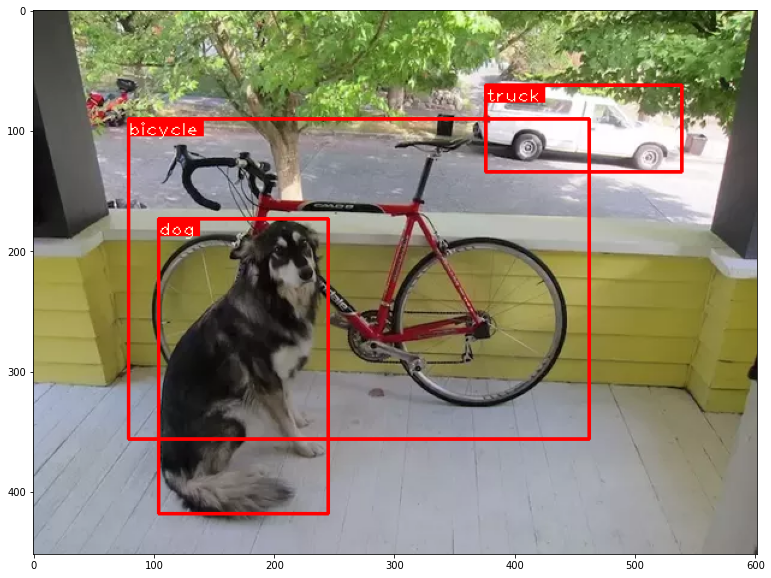

In [16]:
img = cv2.imread('./output/det_input.png') 
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(img)